In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. 환경 설정
### 1) 파이토치, 시각화 라이브러리 로드

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### 2) Hyperparameter

In [13]:
content_layer_num = 1 # 컨텐츠 손실을 어느 지점에서 맞출것인지 지정해놓습니다.
image_size = 512 # 사용할(변환할) 이미지 크기 => 기존에 학습된 ResNet 모델 활용을 위한 크기 변환
epoch = 5000 # 학습 반복 횟수

## 2. Data
### 1) Directory

In [25]:
content_dir = "/content/drive/MyDrive/Colab Notebooks/Image_translation/image/content/Neckarfront_origin.jpg"
# 겨울왕국
style_dir = "/content/drive/MyDrive/Colab Notebooks/Image_translation/image/style/disney.jpg"
# 몽크 - 절규
# /content/drive/MyDrive/Colab Notebooks/Image_translation/image/style/der_schrei.jpg
# Kandinsky
# /content/drive/MyDrive/Colab Notebooks/Image_translation/image/style/kandinsky.jpg
# 모네
# /content/drive/MyDrive/Colab Notebooks/Image_translation/image/style/monet.jpg
# 고흐 별밤
# /content/drive/MyDrive/Colab Notebooks/Image_translation/image/style/StarryNight.jpg

### 2) Prepocessing Function
- 전처리 함수

In [5]:
# 기존에 학습된 ResNet 모델 활용을 위한 크기 변환
def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size), # 이미지 크기 변환
                    transforms.CenterCrop(image_size), # 가운데서 Crop
                    transforms.ToTensor(), # tensor로 변환
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[1,1,1]), # 정규화
                ])
    img = transform(img).view((-1,3,image_size,image_size)) # R,G,B 3 채널 512x512 크기 이미지 셋으로 변환
    return img

### 3) Post processing Function
- 후처리 함수

In [6]:
# 정규화 된 상태로 연산을 진행하고 다시 이미지화 해서 보기위해 뺐던 값들을 다시 더해줍니다.
# 또한 이미지가 0에서 1사이의 값을 가지게 해줍니다.

def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1,1,1]) # 정규화
    img = transform(tensor.clone()) # 현재 tensor의 이미지 추출
    img = img.clamp(0,1) # 이미지가 0~1 사이 값을 가지도록 변경 E.g. -0.5 -> 0 / 1.2 -> 1
    img = torch.transpose(img,0,1) # 0차원 <-> 1차원
    img = torch.transpose(img,1,2) # 1차원 <-> 2차원
    return img

## 3. Model & Loss Function
### 1) Resnet

In [26]:
# 기학습된 resnet50 가중치 사용
resnet = models.resnet50(pretrained=True)
for name,module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


### 2) Delete Fully Connected Layer

In [8]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])
   
    # 레이어마다 결과값을 가져올 수 있게 forward를 정의.
    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

### 3) Gram Matrix Function

In [9]:
# 그람행렬을 생성하는 클래스 및 함수를 정의. 
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size() # [batch,channel,height,width] -> [b,c,h*w]
        F = input.view(b, c, h*w) # [b,c,h*w] x [b,h*w,c] = [b,c,c]
        G = torch.bmm(F, F.transpose(1,2)) # batch matrix multiplication
        return G

### 4) Model on GPU

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

resnet = Resnet().to(device)

# resnet은 학습 대상이 아니기 때문에 requires_grad를 False로 설정
for param in resnet.parameters():
    param.requires_grad = False 

cuda:0


### 5) Gram Matrix Loss

In [28]:
# 그람행렬간의 손실을 계산하는 클래스 및 함수를 정의

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

## 4. Train
### 1) Prepare Images

False False True


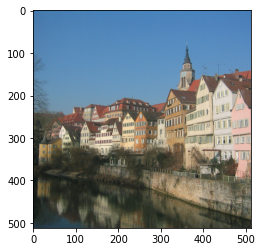

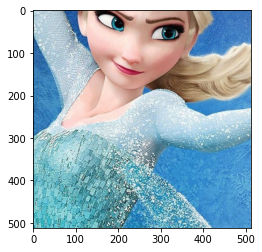

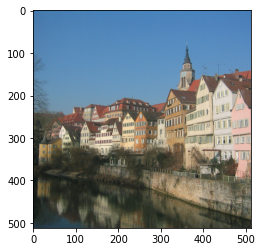

In [29]:
# 컨텐츠 이미지, 스타일 이미지, 학습의 대상이 되는 이미지를 정의합니다.

content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)

print(content.requires_grad,style.requires_grad,generated.requires_grad)

# 각각을 시각화 합니다.

plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

### 2) Set Targets & Style Weights

In [30]:
style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

### 3) Train

In [33]:
optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        
        # 스타일 손실을 각각의 목표값에 따라 계산하고 이를 리스트로 저장
        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        
        # 컨텐츠 손실은 지정한 위치에서만 계산되므로 하나의 수치로 저장
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)
        
        # 스타일:컨텐츠 = 1000:1의 비중으로 손실 계산
        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss

    optimizer.step(closure)

tensor(0.1969, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1959, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1949, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1938, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1928, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1918, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1908, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1898, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1888, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1878, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1856, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1846, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1836, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1825, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1814, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1804, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1794, device='cuda:0', grad_fn=<AddBack

## 5. Check Results

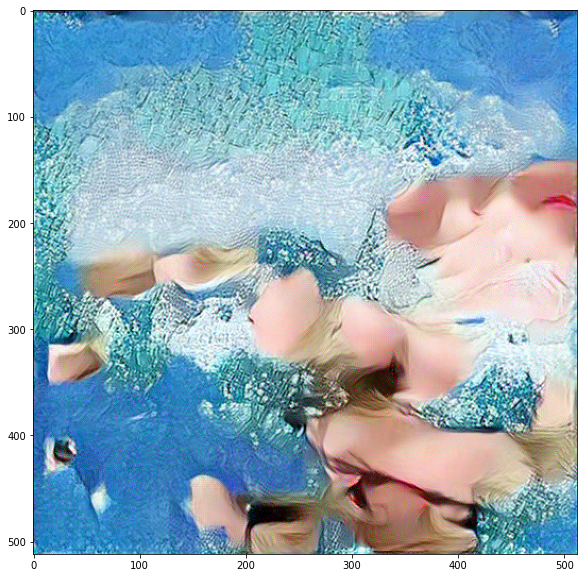

In [34]:
gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()